In [ ]:
## This is a series of examples using the icanswim/cosmosis data science and machine learning repo

In [1]:
from model import FFNet, tv_model
from learning import Learn, Selector, Metrics
from dataset import CDataset, SKDS, TVDS
from dataset import ImageDatasetStats, AsTensor, Squeeze, DType

from torch.optim import Adam
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

In [2]:
!conda list

# packages in environment at /home/operat0r/miniconda3/envs/cosmo:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             5.1                       1_gnu  
anyio                     3.7.0              pyhd8ed1ab_1    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py311h5eee18b_0  
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.2              pyhd8ed1ab_0    conda-forge
attrs                     23.1.0             pyh71513ae_1    conda-forge
babel                     2.12.1             pyhd8ed1ab_1    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cac

In [3]:
#example cosmosis dataset (CDataset)
import numpy as np

class ExampleDataset(CDataset):

    def load_data(self, boom='bust'):
        
        datadic = {1: {'feature_1': np.asarray([.04]),
                       'feature_2': np.asarray([.02]),
                       'feature_3': np.asarray(['z1']),
                       'feature_4': np.asarray(['c','c','d']),
                       'feature_5': np.asarray([1.1])},
                   2: {'feature_1': np.asarray([.03]),
                       'feature_2': np.asarray([.01]),
                       'feature_3': np.asarray(['x1','z1','y1']),
                       'feature_4': np.asarray(['d','a','d']),
                       'feature_5': np.asarray([1.2])}}
        
        self.embed_lookup = {'feature_4': {'a': 1,'b': 2,'c': 3,'d': 4, '0': 0},
                             'feature_3': {'z1': 1, 'y1': 2, 'x1': 3, '0': 0}}
        
        print(boom)
        return datadic
    
class ExampleTransform():
    def __call__(self, arr):
        return np.add(arr, 2)
    
class ExampleTransformTwo():
    def __call__(self, arr):
        return np.multiply(arr, .1)
    
ds_params = {'train_params': {'input_dict': {'model_input': {'X1': ['feature_1','feature_5'],
                                                             'X2': ['feature_5'],
                                                             'embed': ['feature_3']},
                                             'criterion_input': {'target': ['feature_2'],
                                                                 'embed': ['feature_4']}},
                              'transform': [ExampleTransform(), ExampleTransformTwo()],
                              'target_transform': [ExampleTransform()],
                              'pad': (5,),
                              'pad_feats': ['feature_5','feature_4'],
                              'boom': 'bang'}}
    
d = ExampleDataset(**ds_params['train_params'])
d[2]

bang
CDataset created...


{'model_input': {'X1': tensor([0.2030, 0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'X2': tensor([0.3200, 0.2000, 0.2000, 0.2000, 0.2000], dtype=torch.float64),
  'embed': [array([3, 1, 2])]},
 'criterion_input': {'target': tensor([2.0100], dtype=torch.float64),
  'embed': [array([4, 1, 4, 0, 0])]}}

In [4]:
#example cosmosis sklearn regression dataset wrapper SKDS
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_regression',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 5},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32'}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_regression dataset...
CDataset created...


{'model_input': {'features': tensor([ 0.7002,  1.9024, -0.6041, -0.6575, -0.8559])},
 'criterion_input': {'target': tensor([-82.5316])}}

In [5]:
#example cosmosis sklearn classification dataset wrapper (SKDS)
ds_params = {'train_params': {'input_dict': {'model_input': {'features': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'dataset': 'make_classification',
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'sk_params': {'n_samples': 100,
                                            'n_features': 10,
                                            'n_informative': 8,
                                            'n_clusters_per_class': 2,
                                            'flip_y': 0.05,
                                            'class_sep': 0.01,
                                            'n_classes': 4}}}

sk = SKDS(**ds_params['train_params'])

sk[1]

creating scikit learn make_classification dataset...
CDataset created...


{'model_input': {'features': tensor([ 0.0357, -0.1977,  1.0946, -1.7579, -1.5415,  0.3230, -0.2600, -0.5740,
          -0.8194, -0.2443])},
 'criterion_input': {'target': tensor([0])}}

In [6]:
#example cosmosis torchvision image dataset wrapper (TVDS)
ds_params={'dataset': 'MNIST',
           'input_dict': {'model_input': {'features': ['images'],},
                          'criterion_input': {'target': ['labels']}},
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
tvds[1]

creating torch vision MNIST dataset...
CDataset created...


{'model_input': {'image': <PIL.Image.Image image mode=L size=224x224>},
 'criterion_input': {'target': 0}}

In [7]:
#example cosmosis torchvision image dataset wrapper (TVDS) with transforms and PIL stats
ds_params={'dataset': 'MNIST',
           'tv_params': {'root': './data/',
                         'train': True,
                         'download': True,
                         'transform': transforms.Compose([
                                           transforms.Resize(224)]),
                         'target_transform': None}}

tvds = TVDS(**ds_params)
ids = ImageDatasetStats(tvds)

print('mean: ', ids.stats.mean)
print('stddev: ', ids.stats.stddev)

#mean: 33.3/255 = .13
#stddev: 73.7/255 = .29

creating torch vision MNIST dataset...
CDataset created...
images to process: 60000
images processed: 10000
images processed: 20000
images processed: 30000
images processed: 40000
images processed: 50000
images processed: 60000
mean: [33.33091590401786], stddev: [73.70246726596685]
mean:  [33.33091590401786]
stddev:  [73.70246726596685]


creating scikit learn make_regression dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.929232
epoch: 0, lr: 0.01
train loss: 478718.5578703704, val loss: 332175.53125
learning time: 0:00:07.218244
epoch: 10, lr: 0.01
train loss: 8937.776082356771, val loss: 10182.82333096591
test loss: 5798.65889115767
learning time: 0:00:11.652378


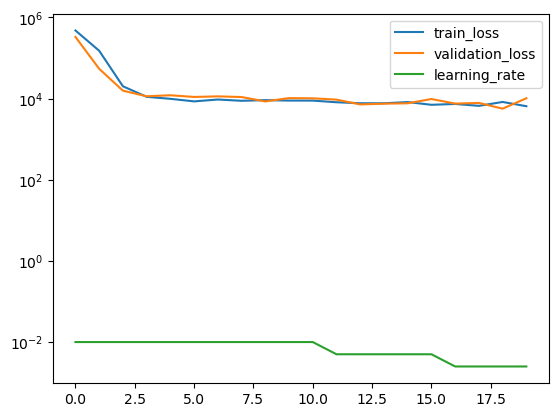

In [8]:
#example cosmosis sklearn regression dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'float32',
                              'dataset': 'make_regression',
                              'as_tensor': True,
                              'transform': [],
                              'sk_params': {'n_samples':20000,
                                            'n_features': 256,
                                            'n_informative': 200}}}
             
metrics_params = {'report_interval': 10,
                  'log_plot': True}                         
             
opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([SKDS], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=MSELoss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20, gpu=True)

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.377085
epoch: 0, lr: 0.01
train loss: 0.010560732916502398, val loss: 0.00997624110080238
sklearn train metric: 0.5905028606499075, sklearn validation metric: 0.6657184454188712
learning time: 0:00:16.468024
epoch: 4, lr: 0.01
train loss: 0.005767910716963092, val loss: 0.005714423222164823
sklearn train metric: 0.8992589541023934, sklearn validation metric: 0.9072585747309483
learning time: 0:00:29.551877
epoch: 8, lr: 0.01
train loss: 0.0036179178442137363, val loss: 0.004062819722482664
sklearn train metric: 0.9572755134525998, sklearn validation metric: 0.949041185201873
test loss: 0.003917686613356201
learning time: 0:00:33.262384
sklearn test metric: 
0.9517689156403553 



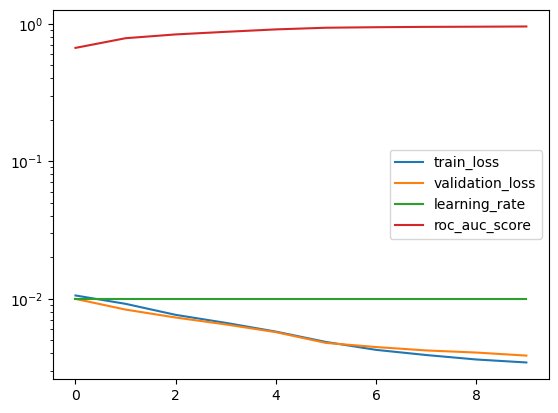

In [9]:
#example cosmosis sklearn classification dataset wrapper (SKDS) with sklearn metrics (Metrics) and 
#custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 100000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10,
                  'log_plot': True,
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          adapt=(300,256,.2), batch_size=128, epochs=10, squeeze_y=True, save_model=True)

In [10]:
#example inference with cosmosis sklearn classification dataset wrapper (SKDS) and custom model (FFNet)
model_params = {'in_channels': 256, 
                'hidden': 128, 
                'out_channels': 4, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['X']},
                                             'criterion_input': {'target': ['y']}},
                              'features_dtype': 'float32',
                              'targets_dtype': 'int64',
                              'dataset': 'make_classification',
                              'sk_params': {'n_samples': 10000,
                                            'n_features': 300,
                                            'n_informative': 200,
                                            'n_clusters_per_class': 3,
                                            'flip_y': 0.05,
                                            'class_sep': 0.1,
                                            'n_classes': 4}}}
                                     
metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score',
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 5,
                'cooldown': 5}

l = Learn([SKDS], 
          FFNet, 
          Sampler=Selector,
          Metrics=Metrics,
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=None,
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=128, epochs=1, squeeze_y=True, load_model='20221025_1522.pth')

creating scikit learn make_classification dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
model loaded from pickle...
running model on gpu...
inference 2023-06-26 17:47:35.200396 complete and saved to csv...


creating torch vision CIFAR10 dataset...


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data/
CDataset created...
creating torch vision CIFAR10 dataset...
Files already downloaded and verified
CDataset created...
torchvision model resnet18 loaded...
running model on gpu...
learning time: 0:00:03.839073
epoch: 0, lr: 0.01
train loss: 2.3508197960853576, val loss: 2.020352094404159
sklearn train metric: 0.644005813913993, sklearn validation metric: 0.7338023392751374
learning time: 0:00:14.366563
epoch: 3, lr: 0.01
train loss: 1.7356478629112244, val loss: 1.7076490752158626
sklearn train metric: 0.8121175063734812, sklearn validation metric: 0.8292701497673061
test loss: 1.7046886262893677
learning time: 0:00:17.152995
sklearn test metric: 
0.8291873777777778 



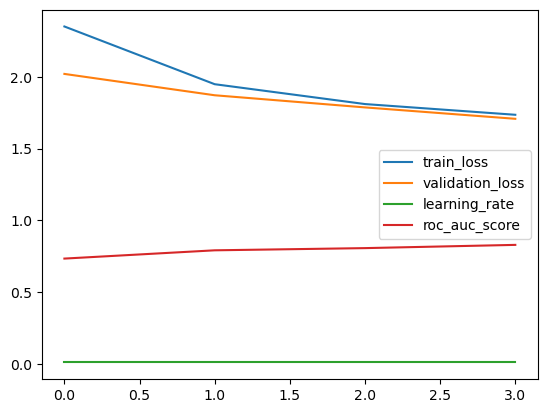

In [11]:
#example cosmosis torchvision image dataset wrapper(TVDS),transforms (transforms) and 
#torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnet18',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'download': True,
                                          'transform': transforms.Compose([
                                                           transforms.RandomRotation(10),
                                                           transforms.Resize(64),
                                                           transforms.ToTensor()]),
                                          'target_transform': None,
                                          'download': True}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'download': True,
                                         'transform': transforms.Compose([
                                                         transforms.Resize(64),
                                                         transforms.ToTensor()]),
                                         'target_transform': None,
                                         'download': True}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 1}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params, 
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=16, epochs=4)

creating torch vision CIFAR10 dataset...
CDataset created...
creating torch vision CIFAR10 dataset...
CDataset created...
torchvision model resnext50_32x4d loaded...
running model on gpu...
learning time: 0:00:56.386367
epoch: 0, lr: 0.01
train loss: 2.629980366230011, val loss: 2.0721995811308584
sklearn train metric: 0.6083320848160254, sklearn validation metric: 0.7137081707843159
learning time: 0:01:52.950744
epoch: 1, lr: 0.01
train loss: 2.026457649230957, val loss: 1.968403447058893
sklearn train metric: 0.7194642596717384, sklearn validation metric: 0.7701359421185627
learning time: 0:02:49.704985
epoch: 2, lr: 0.01
train loss: 1.9639420490264892, val loss: 1.8962080882441612
sklearn train metric: 0.7444315343505035, sklearn validation metric: 0.779323303558955
learning time: 0:03:46.529711
epoch: 3, lr: 0.01
train loss: 1.9033802599906922, val loss: 1.9163780346993478
sklearn train metric: 0.764038206814184, sklearn validation metric: 0.777929043903381
test loss: 1.89402348976

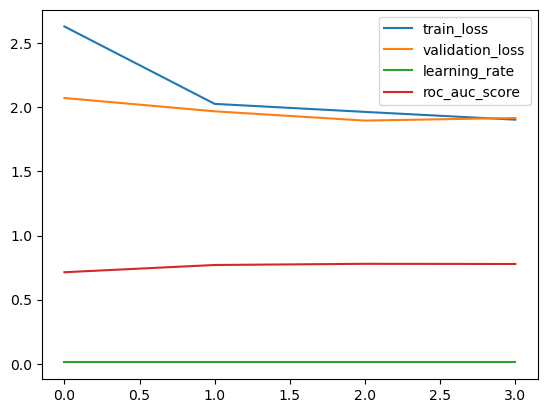

In [12]:
#example cosmosis torchvision dataset wrapper (TVDS) and torchvision model wrapper (tv_model)
model_params = {'model_name': 'resnext50_32x4d',
                'in_channels': 3,
                'tv_params': {'num_classes': 10}}

ds_params={'train_params': {'dataset': 'CIFAR10',
                            'tv_params': {'root': './data/',
                                          'train': True,
                                          'transform': transforms.Compose([
                                                       transforms.RandomRotation(10),
                                                       transforms.Resize(256),
                                                       transforms.ToTensor()]),
                                          'target_transform': None}},
           'test_params': {'dataset': 'CIFAR10',
                           'tv_params': {'root': './data/',
                                         'train': False,
                                         'transform': transforms.Compose([
                                                      transforms.Resize(256),
                                                      transforms.ToTensor()]),
                                         'target_transform': None}}}

metrics_params = {'report_interval': 10, 
                  'sk_metric_name': 'roc_auc_score', 
                  'sk_params': {'average': 'macro',
                                'multi_class': 'ovr'}}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.8,),
                 'subset': .1}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 2}

l = Learn([TVDS,TVDS], 
          tv_model, 
          Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=CrossEntropyLoss, 
          model_params=model_params, ds_params=ds_params, 
          sample_params=sample_params, opt_params=opt_params, 
          sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=16, epochs=4)